<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 50px"><b>But de ce Notebook</b></h2>
<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Dans ce notebook, nous allons donner une définition novice de la sinistralité, et nous allons implémenter différents algorithmes prédictifs pour prédire la sinistralité pour 2025.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Définition de la sinistralité</b></h2>

<p style="font-family: Arial, sans-serif; font-size: 20px; color:white;">
En nous inspirant de la bibliographie 2, nous allons utiliser la définition suivante de la dérive de sinistralité :
</p>

$$
\text{dérive de sinistralité(2025)} = \frac{RAC_{est, 2025}}{RAC_{2024}} -1\\

\text{où $RAC_{est, 2025}$ est le reste à charge estimé de l'année 2025}\\

\text{et $RAC_{2024}$ est le reste à charge de l'année 2024}
$$


<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Nous allons alors nous intéresser à la prédiction du reste à charge qui nous donnera la dérive de sinistralité pour l'année 2025.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Chargement des données et leurs visualisations</b></h2>

In [55]:
import pandas as pd
import numpy as np

df = pd.read_csv("../../page 3/RAC_par_mois.csv")

In [56]:
df

,Year,Month,AGE_BEN_SNDS,BEN_SEX_COD,RAC,FLT_PAI_MNT
0,2019,1,0,0,2.469000e+01,2.100380e+03
1,2019,1,0,1,2.155085e+08,6.103766e+08
2,2019,1,0,2,2.279055e+08,5.659390e+08
3,2019,1,20,1,7.810935e+07,2.442605e+08
4,2019,1,20,2,1.280728e+08,3.902393e+08
...,...,...,...,...,...,...
1622,2024,12,80,1,1.543962e+08,9.637709e+08
1623,2024,12,80,2,2.634141e+08,1.362849e+09
1624,2024,12,99,0,8.802047e+04,3.824830e+07
1625,2024,12,99,1,2.589129e+05,4.016202e+06


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Filtrage des données</b></h2>

On enlève les valeurs inconnues pour le sexe et l'âge et on ne garde que les données agrégés mensuellement

In [57]:
df_filtered = df[(df['AGE_BEN_SNDS'] != 99) & (df['BEN_SEX_COD'] != 0)]

df_grouped = df_filtered.drop(columns = ['BEN_SEX_COD', 'AGE_BEN_SNDS', 'FLT_PAI_MNT']).groupby(by = ['Year', 'Month']).sum()

df_grouped.reset_index(inplace=True)

df_grouped.head()

,Year,Month,RAC
0,2019,1,3.077760e+09
1,2019,2,2.947452e+09
2,2019,3,3.157757e+09
3,2019,4,3.235090e+09
4,2019,5,3.129179e+09


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création d'un champ date</b></h2>

In [58]:
df_grouped["date"] = pd.to_datetime(df_grouped[["Year", "Month"]].assign(day=1))

# Sort by date
df_grouped = df_grouped.sort_values("date")

df_grouped

,Year,Month,RAC,date
0,2019,1,3.077760e+09,2019-01-01
1,2019,2,2.947452e+09,2019-02-01
2,2019,3,3.157757e+09,2019-03-01
3,2019,4,3.235090e+09,2019-04-01
4,2019,5,3.129179e+09,2019-05-01
...,...,...,...,...
67,2024,8,2.633835e+09,2024-08-01
68,2024,9,3.555795e+09,2024-09-01
69,2024,10,4.310012e+09,2024-10-01
70,2024,11,3.564801e+09,2024-11-01


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Visualisation du reste à charge</b></h2>

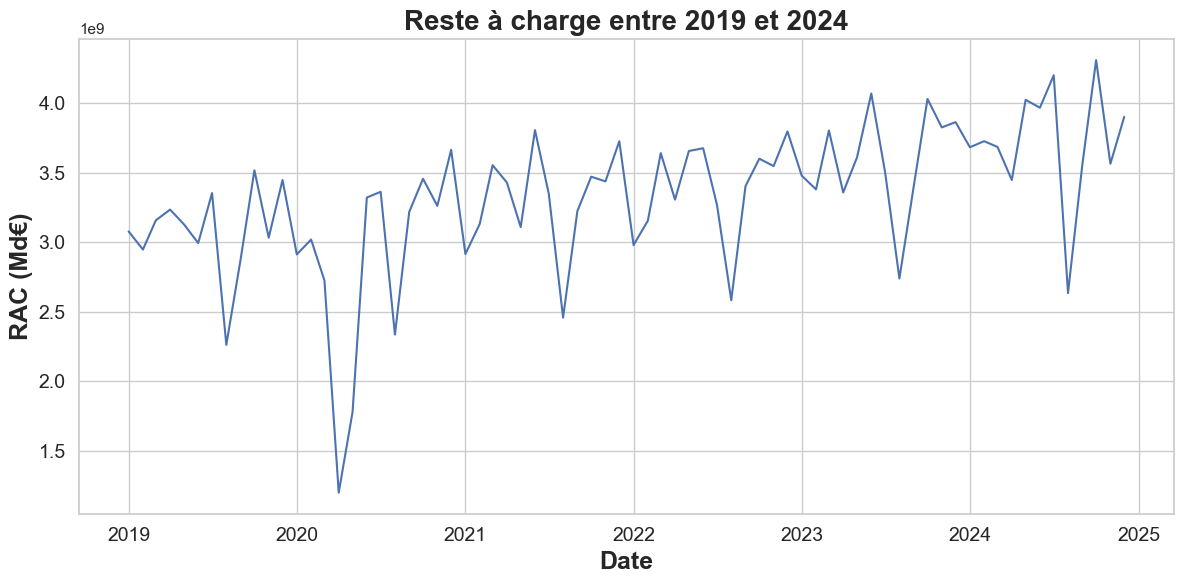

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(x="date", y="RAC", data=df_grouped)

# Title with bigger font
plt.title("Reste à charge entre 2019 et 2024", fontsize=20, fontweight='bold')

# Axis labels with bigger font
plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("RAC (Md€)", fontsize=18, fontweight='bold')

# Optional: Ticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création des variable de saisonalité et de tendance</b></h2>

On observe une tendance linéaire au fil des années !

In [60]:
df_grouped["tendance"] = range(len(df_grouped))  


Des tendances annuelles sont aussi visualisées, des chutes de RAC pendant l'été et une augmentation de cette dernière en mois d'hiver. Cependant, une exception est vue lors de l'année 2020 à cause de la crise sanitaire du covid 19.

In [61]:
import numpy as np
import pandas as pd

"""# Let's assume df_grouped is your DataFrame and it already has the "tendance" column.
period = 12  # Yearly seasonality
nbr_harmonics = 20  # Number of harmonics you want to generate

# Create a list of new sin and cos columns
sin_columns = []
cos_columns = []

for k in range(1, nbr_harmonics + 1):
    sin_columns.append(np.sin(2 * np.pi * k * df_grouped["tendance"] / period))
    #cos_columns.append(np.cos(2 * np.pi * k * df_grouped["tendance"] / period))

# Create a DataFrame with sin and cos columns
sin_df = pd.DataFrame({f'sin_{k}': sin_columns[k-1] for k in range(1, nbr_harmonics + 1)})
#cos_df = pd.DataFrame({f'cos_{k}': cos_columns[k-1] for k in range(1, nbr_harmonics + 1)})

# Concatenate sin and cos DataFrames with the original DataFrame
df_grouped = pd.concat([df_grouped, sin_df], axis=1)"""

# Now df_grouped contains all the original data plus the sin and cos features.


'# Let\'s assume df_grouped is your DataFrame and it already has the "tendance" column.\nperiod = 12  # Yearly seasonality\nnbr_harmonics = 20  # Number of harmonics you want to generate\n\n# Create a list of new sin and cos columns\nsin_columns = []\ncos_columns = []\n\nfor k in range(1, nbr_harmonics + 1):\n    sin_columns.append(np.sin(2 * np.pi * k * df_grouped["tendance"] / period))\n    #cos_columns.append(np.cos(2 * np.pi * k * df_grouped["tendance"] / period))\n\n# Create a DataFrame with sin and cos columns\nsin_df = pd.DataFrame({f\'sin_{k}\': sin_columns[k-1] for k in range(1, nbr_harmonics + 1)})\n#cos_df = pd.DataFrame({f\'cos_{k}\': cos_columns[k-1] for k in range(1, nbr_harmonics + 1)})\n\n# Concatenate sin and cos DataFrames with the original DataFrame\ndf_grouped = pd.concat([df_grouped, sin_df], axis=1)'

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Le GLM</b></h2>

In [62]:
import statsmodels.api as sm

features = ["tendance"]
for k in range(2, 13): 
    #features.append(f'sin_{k}')
    #features.append(f'cos_{k}')
    features.append(f'Month_{k}')

#create dummy variables for the month
df_grouped = pd.get_dummies(df_grouped, columns=["Month"], prefix="Month", drop_first=True, dtype=int)
print(df_grouped)
train_cutoff = pd.Timestamp("2024-01-01")
train_beginning = pd.Timestamp("2021-01-01")
#df_train = df_grouped[df_grouped["date"] < train_cutoff]
df_train = df_grouped[(df_grouped["date"] < train_cutoff) & (df_grouped["date"] >= train_beginning )].copy()
df_test = df_grouped[df_grouped["date"] >= train_cutoff].copy()

X_train = sm.add_constant(df_train[features])
y_train = df_train["RAC"]

X_test = sm.add_constant(df_test[features])
y_test = df_test["RAC"]


model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
results = model.fit()
print(results.summary())

    Year           RAC       date  tendance  Month_2  Month_3  Month_4  \
0   2019  3.077760e+09 2019-01-01         0        0        0        0   
1   2019  2.947452e+09 2019-02-01         1        1        0        0   
2   2019  3.157757e+09 2019-03-01         2        0        1        0   
3   2019  3.235090e+09 2019-04-01         3        0        0        1   
4   2019  3.129179e+09 2019-05-01         4        0        0        0   
..   ...           ...        ...       ...      ...      ...      ...   
67  2024  2.633835e+09 2024-08-01        67        0        0        0   
68  2024  3.555795e+09 2024-09-01        68        0        0        0   
69  2024  4.310012e+09 2024-10-01        69        0        0        0   
70  2024  3.564801e+09 2024-11-01        70        0        0        0   
71  2024  3.901916e+09 2024-12-01        71        0        0        0   

    Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  
0         0        0        0  

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Valeurs prédites par le GLM</b></h2>

Train MAPE: 15.29%
Test MAPE:  26.34%


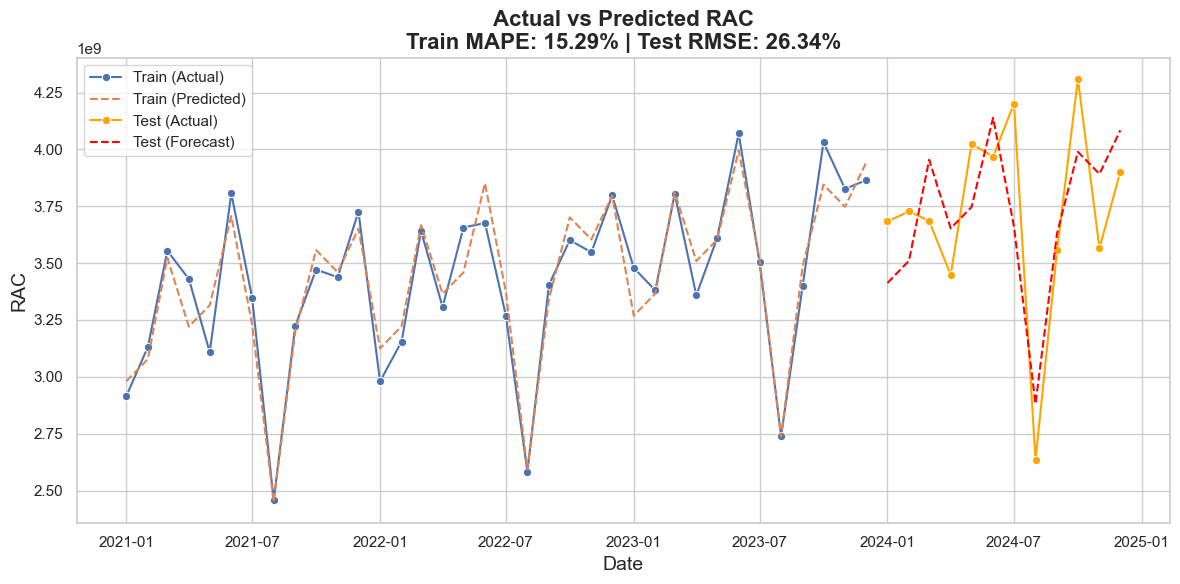

'Train MAPE: 18.49%\nTest MAPE:  27.16%'

In [63]:
from sklearn.metrics import mean_absolute_percentage_error
df_test["predicted_RAC"] = results.predict(X_test)
df_train["predicted_RAC"] = results.predict(X_train)
# Calculate RMSE for Train
rmse_train = np.sqrt(mean_absolute_percentage_error(df_train["RAC"], df_train["predicted_RAC"]))

# Calculate RMSE for Test
rmse_test = np.sqrt(mean_absolute_percentage_error(df_test["RAC"], df_test["predicted_RAC"]))

# Print them
print(f"Train MAPE: {rmse_train*100:.2f}%")
print(f"Test MAPE:  {rmse_test*100:.2f}%")
plt.figure(figsize=(12, 6))

# Training period
sns.lineplot(x="date", y="RAC", data=df_train, label="Train (Actual)", marker='o')
sns.lineplot(x="date", y=results.predict(X_train), data=df_train, label="Train (Predicted)", linestyle='--')

# Testing period
sns.lineplot(x="date", y="RAC", data=df_test, label="Test (Actual)", marker='o', color='orange')
sns.lineplot(x="date", y="predicted_RAC", data=df_test, label="Test (Forecast)", linestyle='--', color='red')

plt.title(f"Actual vs Predicted RAC\nTrain MAPE: {rmse_train*100:.2f}% | Test RMSE: {rmse_test*100:.2f}%", 
          fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("RAC", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

"""Train MAPE: 18.49%
Test MAPE:  27.16%"""

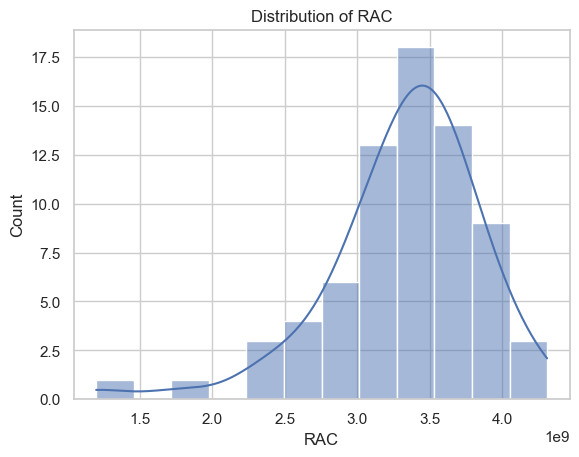

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_grouped['RAC'], kde=True)  # Add a kernel density estimate to help visualize the distribution
plt.title('Distribution of RAC')
plt.show()

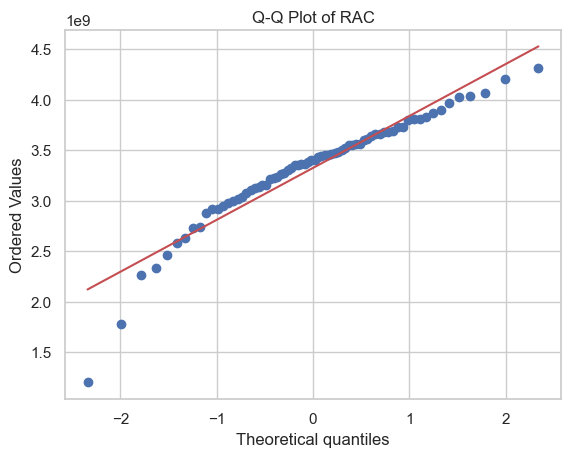

In [65]:
import scipy.stats as stats

stats.probplot(df_grouped['RAC'], dist="norm", plot=plt)
plt.title('Q-Q Plot of RAC')
plt.show()

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Ajout de variables exogènes Sexe, population, age</b></h2>